# STAT5243 Project 3: Imbalanced image classification

#### Group 2: 
    Yibai Liu (yl4616) 
    Wendy Doan (ad3801)
    Siyuan Sang (ss6165)
    Feng Rong (fr2467)
    Hao Hu (hh2874)
 

## Step 0: Set up

#### Set up controls for the evaluation experiments.

In [390]:
RUN_TEST = False # run evaluation on the test set 

READ_PTS = True # read fiducial points from directory
if RUN_TEST:
    RUN_SEARCH = False
    RUN_CV = False
    SAVE_FEATURE = False
    FIT_MODEL = False
    READ_IMG = False
else:
    RUN_SEARCH = True # run grid search on the training set to tune hyperparameters
    RUN_CV = True # run cross-validation on the training set
    SAVE_FEATURE = True # save extracted feature sets
    FIT_MODEL = True # fit models
    READ_IMG = False # read images from directory

In [300]:
%run "../lib/functions.py" #general functions
%run "../lib/feature.py" #feature extraction
%run "../lib/test.py" #predict function
if not RUN_TEST:
    %run "../lib/train.py" # model training functions, models with tuned hyperparameters
    %run "../lib/validation.py" # cross validation and grid search functions, 
                                 # parameter grids of all models for tuning  

<Figure size 432x288 with 0 Axes>

In [246]:
import os
wd = os.getcwd()
output_dir = os.path.join(os.path.dirname(wd), "output\\")
output_dir

'C:\\Users\\Chloe\\Documents\\R\\Spring2021-Project3-group-2\\output\\'

#### Install libraries as needed: 

If you want to run this notebook, you would need to install two packages [**tensorflow**](https://www.tensorflow.org/install) and [**xgboost**](https://anaconda.org/conda-forge/xgboost)

Note: xgboost library can be installed by running `!conda install -c conda-forge xgboost` in a cell or in the Anaconda prompt without the `!` mark. 
For tensorflow, Google colab has tensorflow installed, but if you use Anaconda jupyter notebook, you could copy and paste `conda install -c conda-forge tensorflow` into the Anaconda prompt or install tensorflow inside a jupyter notebook cell by `!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org --upgrade tensorflow` 

In [4]:
#import tensorflow and check version
import tensorflow as tf
print(tf.__version__)

#import xgboost and check version
import xgboost as xgb
print(xgb.__version__)

2.4.1
1.3.3


#### Import other libraries and set up parameters as needed.

In [298]:
import glob
import cv2
import pandas as pd
import numpy as np
import random
import sys
import time
from joblib import dump, load
import scipy.io as sio
from scipy import spatial
import warnings
warnings.filterwarnings('ignore')
#import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
from itertools import chain
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import sklearn.preprocessing
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier 
from sklearn.ensemble import VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (classification_report, roc_curve, plot_roc_curve, auc, pairwise_distances, 
                             roc_auc_score, brier_score_loss, precision_score, recall_score,f1_score, 
                             accuracy_score, balanced_accuracy_score)
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.model_selection import cross_validate, cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.exceptions import ConvergenceWarning
from sklearn.datasets import make_classification
import xgboost as xgb
from xgboost import XGBClassifier

from tensorflow.keras import datasets, layers, models


# Set a random seed for reproduction.
RANDOM_STATE = np.random.seed(2021)

K = 5  # number of CV folds
NUM_EPOCHS = 100 # number of epochs

%matplotlib inline

#### Next, we need to get the paths to where the datasets are located.

In [6]:
# Reproduction: change paths to where you store the datasets
if RUN_TEST:
    path = 'C:\\Users\\Chloe\\Downloads\\test_set_predict\\'
    #|--test_set_predict
    #   |--points
    #      |--XXXX.mat
    #   |--images
    #      |--XXXX.jpg
    #   |--label_prediction.csv
else:
    path = 'C:\\Users\\Chloe\\Downloads\\train_set\\'

## Step 1: Load data

In [391]:
# Read fiducial points from .mat files
# load_points(path) function in functions.py
if READ_PTS:
    pt_filenames = glob.glob(path + "points/*.mat") #points_path = f"data//train_set//points//{index:04d}.mat"

    start = time.time()
    points_list = [load_points(path) for path in pt_filenames]
    print("Time for reading points data: ", round(time.time()-start,4), "s")
    data_points = np.asarray(points_list, dtype=np.float32)
    print(data_points.shape)
    
    # load labels
    if RUN_TEST == False: 
        labels = pd.read_csv(path+"label.csv")
        print(labels['label'].value_counts())
        n_zeros, n_ones = labels['label'].value_counts()
    else: 
        n_zeros = 2402
        n_one = 598
        print("Training data has:\n  ",n_zeros,"images of class 0\n  ",n_ones,"images of class 1")

# You can load images in order if you need, but we don't run this chunk in test because we didn't use images as features
# Reference： https://appdividend.com/2020/09/19/python-cv2-understand-image-types-and-color-channels/
if READ_IMG:
    filenames = glob.glob(path + "images/*.jpg")
    filenames.sort()
    start = time.time()
    images = [cv2.imread(img) for img in filenames]
    print("Time for reading images: ", round(time.time()-start,4), "s")
    # overview of the dataset
    print("Number of images: ", len(images))
    print("Size of each image: ",images[0].shape)

Time for reading points data:  1.1823 s
(3000, 78, 2)
0    2402
1     598
Name: label, dtype: int64


**_Note: The dataset is imbalanced, and the class ratio is approximately 4:1 where class 1 being the minority class._**

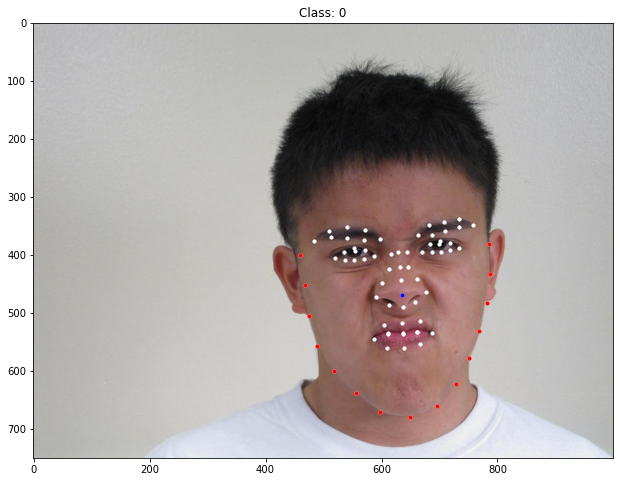

In [212]:
# show_sample_image() function in functions.py
RUN_TEST = False
if RUN_TEST != True: 
    show_sample_image(path, data_points, labels, 1)
    with open(output_dir + 'sample_image_printout.txt', 'w') as f:
        f.write(sample_image.stdout)
else:
    sample_image.show()

Points 64-78 represent the shape of face; point 38 marks the tip of nose which can be seen as the center of face.

## Step 2: Data processing and feature engineering

#### - Feature set 0: pairwise distances (**_euclidean distances_**) between all X coordinates and Y coordinates separately
#### - Feature set 1: pairwise spatial distances (**_cosine distances_**) between points 
#### - Feature set 1 reduced: feature set 1 with 100 predictors/attributes selected
 
_Note: See detailed comparison between **euclidean** and **cosine** distances [here](https://cmry.github.io/notes/euclidean-v-cosine)._

(-0.5, 1197.5, 729.5, -0.5)

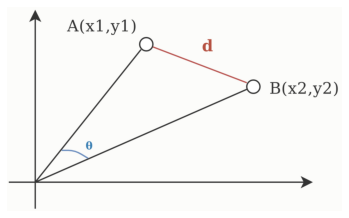

In [394]:
plt.imshow(mpimg.imread('../figs/distance-comparison.png'))
plt.axis('off')

### Train/test split

In [392]:
# Feature sets generating functions get_feature_0(), get_feature_1(), get_reduced_feature_1() in feature.py

# For testing
if RUN_TEST:
    X1r_tt, tm1r_tt = get_reduced_feature_1(data_points, y= np.empty([1,]), save_name = 'feature1_reduced_test')
    print("Time for extracting reduced feature set 1 for the test data: ", tm1r_tt, "s")
    print("="*30)
    print("Shapes of testing feature sets:")
    print("Feature set 1 reduced:", X1r_tt.shape)
    
# For training
else:
    X_train, X_test, y_train, y_test= train_test_split(range(3000), labels['label'], 
                                                       test_size=0.2, random_state = RANDOM_STATE)
    ones_in_train = y_train[labels['label']==1]  #n_ones_train, n_zeros_train = y_train.value_counts()
    zeros_in_train = y_train[labels['label']==0] #n_ones_test, n_zeros_test = y_test.value_counts()
    y_tr = np.array(y_train)
    y_tt = np.array(y_test)
    
    print("Train/test split size: (80%, 20%)")
    print('Class weight in training split:', round(y_train.value_counts()[0]/y_train.value_counts()[1],1), ':1')
    print('Class weight in testing split:', round(y_test.value_counts()[0]/y_test.value_counts()[1],1), ':1')     
    print("="*30)
    
    # Training split
    if SAVE_FEATURE:
        X0_tr, tm0_tr = get_feature_0(data_points[X_train], save_name = 'feature0_tr')
        print("Time for extracting feature set 0 for training split: ", tm0_tr, "s")
        X1r_tr, tm1r_tr = get_reduced_feature_1(data_points[X_train], y_tr, save_name = 'feature1_tr_reduced')
        print("Time for extracting reduced feature set 1 for training split: ", tm1r_tr, "s")
    else: 
        X0_tr, tm0_tr = get_feature_0(data_points[X_train], save_name = '')
        print("Time for extracting feature set 0 for training split: ", tm0_tr, "s")
        X1r_tr, tm1r_tr = get_reduced_feature_1(data_points[X_train], y_tr, save_name = '')
        print("Time for extracting reduced feature set 1 for training split: ", tm1r_tr, "s")    
    
    # Test split
    print("="*30)
    X0_tt, tm0_tt = get_feature_0(data_points[X_test], save_name = '')
    print("Time for extracting feature set 0 for tesing split: ", tm0_tt, "s")
    X1r_tt, tm1r_tt = get_reduced_feature_1(data_points[X_test], y= np.empty([1,]), rescale='robust', save_name = '')
    print("Time for extracting reduced feature set 1 for testing split: ", tm1r_tt, "s")
    print("="*30)
    print("Shapes of training feature sets:")
    print("Feature set 0:", X0_tr.shape, "; feature set 1 reduced:", X1r_tr.shape)
    print("Shapes of testing feature sets:")
    print("Feature set 0:", X0_tt.shape, "; feature set 1 reduced:", X1r_tt.shape)

Train/test split size: (80%, 20%)
Class weight in training split: 4.1 :1
Class weight in testing split: 3.7 :1
Time for extracting feature set 0 for training split:  9.9126 s
-----
Importance of 10 most critical fiducial points in 100 selected pairwise distances: 
Point: 53 , frequency: 23
Point: 11 , frequency: 20
Point: 52 , frequency: 15
Point: 6 , frequency: 9
Point: 29 , frequency: 8
Point: 30 , frequency: 8
Point: 12 , frequency: 7
Point: 18 , frequency: 7
Point: 46 , frequency: 7
Point: 47 , frequency: 7
-----
Time for extracting reduced feature set 1 for training split:  1.007 s
Time for extracting feature set 0 for tesing split:  2.705 s
-----
Importance of 10 most critical fiducial points in 100 selected pairwise distances: 
Point: 53 , frequency: 23
Point: 11 , frequency: 20
Point: 52 , frequency: 15
Point: 6 , frequency: 9
Point: 29 , frequency: 8
Point: 30 , frequency: 8
Point: 12 , frequency: 7
Point: 18 , frequency: 7
Point: 46 , frequency: 7
Point: 47 , frequency: 7
---

## Step 3: Model training and validation

We mostly utilized machine learning classification models from Scikit-learn library. We first created baseline models for each classifier, and fitted models with different feature sets and tuned hyperparameters by grid search.

 - Model 0: Baseline Gradient Boosting Machine (GBM) -- with feature set 0
 - Model 1: Fast GBM 
 - Model 2: Logistic Regression 
 - Model 3: AdaBoost with base estimator BaggingClassifier 
 - Model 4: Multi-layer Perceptron Classifier 
 - Model 5: Stochastic Gradient Descent  
 - Model 6: Linear Discriminant Analysis
 - Model 7: Guissian Naive Bayes
 - Model 8: Bagging Classifier with base estimator ExtraTreesClassifier
 - Model 9: XGBoosting 
 - Model 10: VotingClassifier (with reduced feature set 1)
 - Model 11: K Nearest Neighbors Classifier 
 - Model 12: Support Vector Machine 
 - Model 13: Tensorflow Deep Neural Networks
 - Model 14: Random Forest (developed in R)
 - Model 15: SVM+PCA (developed in R)

_Note: Except for the baseline GBM model, the Random Forest model and SVM+PCA model in R, all models used the reduced feature set 1. Models above all have been tuned by grid search on AUC optimization._

In [22]:
# If RUN_SEARCH == False, load the tuned models
# If RUN_SEARCH == True, re-run the grid search for all models
if RUN_SEARCH:
    # grid_search() function in validation.py
    fast_gbm_c = grid_search(X1r_tr, y_tr, baseline_gbm, param_grid_gbm, cv=K, print_step = False, refit = 'roc_auc')
    LR_c = grid_search(X1r_tr, y_tr, baseline_lr, param_grid_lr, cv=K, print_step = False, refit = 'roc_auc')
    ADA_c = grid_search(X1r_tr, y_tr, baseline_ada, param_grid_ada, cv=K, print_step = False, refit = 'roc_auc')
    MLP_c = grid_search(X1r_tr, y_tr, baseline_mlp, param_grid_mlp, cv=K, print_step = False, refit = 'roc_auc')
    SGD_c = grid_search(X1r_tr, y_tr, baseline_sgd, param_grid_sgd, cv=K, print_step = False, refit = 'roc_auc')
    LDA_c = grid_search(X1r_tr, y_tr, baseline_lda, param_grid_lda, cv=K, print_step = False, refit = 'roc_auc')
    GNB_c = grid_search(X1r_tr, y_tr, baseline_gnb, param_grid_gnb, cv=K, print_step = False, refit = 'roc_auc')
    BAG_c = grid_search(X1r_tr, y_tr, baseline_bag, param_grid_bag, cv=K, print_step = False, refit = 'roc_auc')
    XGB_c = grid_search(X1r_tr, y_tr, baseline_xgb, param_grid_xgb, cv=K, print_step = False, refit = 'roc_auc')
    VOT_c = grid_search(X1r_tr, y_tr, baseline_vot, param_grid_vot, cv=K, print_step = False, refit = 'roc_auc')
    KNN_c = grid_search(X1r_tr, y_tr, baseline_knn, param_grid_knn, cv=K, print_step = False, refit = 'roc_auc')
    SVC_c = grid_search(X1r_tr, y_tr, baseline_svc, param_grid_svc, cv=K, print_step = False, refit = 'roc_auc')


In [14]:
model_lbs = ['baseline GBM','fast GBM','LR','ADA','MLP','SGD','GNB','LDA','BAG','VOT','XGB','KNN','SVC']

# If FIT_MODEL == True, re-run the training/fitting for all models and save them in a list
if FIT_MODEL:
    # train() function in train.py
    tuned_models = [baseline_gbm, fast_gbm_c, LR_c, 
              ADA_c, MLP_c, SGD_c, GNB_c, LDA_c,
              BAG_c, VOT_c,XGB_c, KNN_c, SVC_c]
    models=[]
    tm_fit=[]
    for i in range(len(model_lbs)):
        m = tuned_models[i]
        label = model_lbs[i]
        if label != 'baseline GBM':
            m_fit, tm_m_fit = train(m, X1r_tr, y_tr)
        else:
            m_fit, tm_m_fit = train(m, X0_tr, y_tr)
        models.append(m_fit)
        tm_fit.append(tm_m_fit)
    
    dump(models, output_dir +'fitted_models.joblib')
    dump(tm_fit, output_dir +'training_time.joblib')

# If FIT_MODEL == False, load the fitted models
else:
    models = load(output_dir +'fitted_models.joblib')
    tm_fit = load(output_dir +'training_time.joblib')


In [373]:
# To run kfold CV on tuned model:

# function kfold_cv() in validation.py
if not RUN_CV:
    CV_results = load(output_dir +'CV_results.joblib')
else:
    cv_fpr = []
    cv_tpr = []
    cv_mean_auc =[]
    cv_mean_acc =[]
    cv_std_auc = []
    cv_std_acc=[]
    for i in range(len(model_lbs)):
        clf = models[i]
        label = model_lbs[i]

        if lb != 'baseline GBM':
            fpr, tpr, mean_auc, std_auc, mean_acc, std_acc = kfold_cv(clf, X1r_tr, y_tr, K = 5, lb=label, plot_roc=False)
        else: #baseline GBM uses feature set 0
            fpr, tpr, mean_auc, std_auc, mean_acc, std_acc = kfold_cv(clf, X0_tr, y_tr, K = 5, lb=label, plot_roc=False)
        cv_fpr.append(fpr)
        cv_tpr.append(tpr)
        cv_mean_auc.append(mean_auc)
        cv_mean_acc.append(mean_acc)
        cv_std_auc.append(std_auc)
        cv_std_acc.append(std_acc)
    cv_auc = [p(auc, std) for (auc,std) in zip(cv_mean_auc,cv_std_auc)]
    cv_acc = [p(acc, std) for (acc,std) in zip(cv_mean_acc,cv_std_acc)]
    CV_results = pd.DataFrame({'Model': model_lbs,'Mean AUC':cv_auc,'Mean Accuracy':cv_acc})
    dump(CV_results, output_dir +'CV_results.joblib')

CV_results.sort_values('Mean AUC', axis=0, ascending=False)

,Model,Mean AUC,Mean Accuracy
4,MLP,0.8037 (+/-0.0089),0.8317 (+/-0.0082)
9,VOT,0.7954 (+/-0.0153),0.8267 (+/-0.0085)
1,fast GBM,0.7498 (+/-0.012),0.815 (+/-0.001)
2,LR,0.7468 (+/-0.0167),0.8154 (+/-0.0144)
10,XGB,0.7438 (+/-0.0099),0.8046 (+/-0.0149)
7,LDA,0.7387 (+/-0.0131),0.8158 (+/-0.0072)
3,ADA,0.7366 (+/-0.0136),0.8112 (+/-0.0088)
12,SVC,0.7291 (+/-0.0128),0.8171 (+/-0.0118)
8,BAG,0.7206 (+/-0.0126),0.8025 (+/-0.0071)
0,baseline GBM,0.71 (+/-0.022),0.8125 (+/-0.0027)


## Step 4: Model evaluation and model selection

Since our problem is classification of imbalanced data, we focused more on metrics like balanced accuracy and AUC rather than the traditional accuracy. We also extracted a balanced accuracy score to compare performances.

### Run tests on the testing split

In [352]:
%%capture roc_curves

models = load(output_dir +'fitted_models.joblib')
plt.figure(figsize=(10, 10))
roc_gmeans(model=baseline_gbm_fit, lb='Baseline GBM', X_test=X0_tt, y_test=y_tt, color='black')
for (m,lb) in zip(models[1:13],model_lbs[1:13]):
    roc_gmeans(model=m, lb=lb, X_test=X1r_tt, y_test=y_tt,dnn=False)
roc_gmeans(model=DNN2, lb='DNN', X_test=X1r_tt, y_test=y_tt, color='yellow',dnn=True)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
# axis labels
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

with open(output_dir + 'roc_curves_printout.txt', 'w') as f:
    f.write(roc_curves.stdout)

Best Threshold for 'Baseline GBM' = 0.219687, G-Mean=0.701
Best Threshold for 'fast GBM' = 0.062713, G-Mean=0.680
Best Threshold for 'LR' = 0.172400, G-Mean=0.685
Best Threshold for 'ADA' = 0.348145, G-Mean=0.686
Best Threshold for 'MLP' = 0.207553, G-Mean=0.749
Best Threshold for 'SGD' = 0.059674, G-Mean=0.670
Best Threshold for 'GNB' = 0.004093, G-Mean=0.578
Best Threshold for 'LDA' = 0.215873, G-Mean=0.671
Best Threshold for 'BAG' = 0.214900, G-Mean=0.671
Best Threshold for 'VOT' = 0.250109, G-Mean=0.743
Best Threshold for 'XGB' = 0.214645, G-Mean=0.668
Best Threshold for 'KNN' = 0.240802, G-Mean=0.690
Best Threshold for 'SVC' = 0.383517, G-Mean=0.651
Best Threshold for 'DNN' = 0.056972, G-Mean=0.707


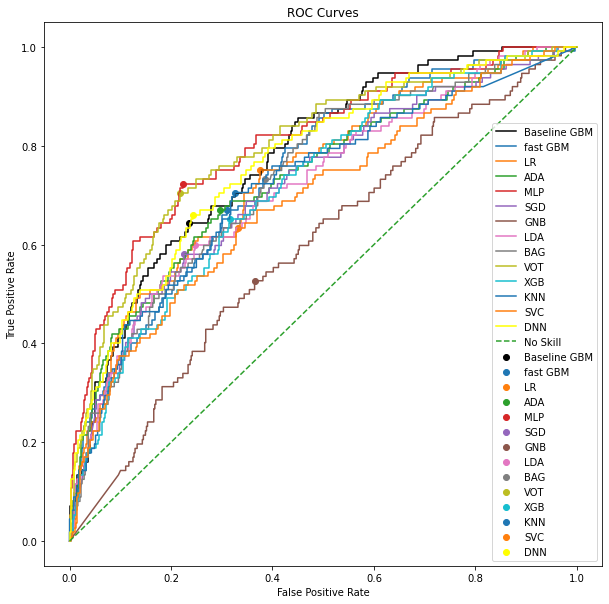

In [353]:
roc_curves.show()

In [377]:
# If RUN_TEST = True, load saved model comparison table
if RUN_TEST:
    log = load(output_dir +'model_comparison_table.joblib')
    tm_test = load(output_dir +'testing_time.joblib')
else:
    log_cols=["Model", "Training time(s)", "Testing time(s)","Claimed Accuracy", "AUC", "Balanced Accuracy"]
    log = pd.DataFrame(columns=log_cols)
    tm_test = []
    
    for i in range(len(models)):
        training_time = tm_fit[i]
        clf = models[i]
        lb = model_lbs[i]
        name = clf.__class__.__name__
    
        if lb != 'baseline GBM':
            yhat, testing_time = predict_results(model = clf, X = X1r_tt)
        else: #baseline GBM uses feature set 0
            yhat, testing_time = predict_results(model = clf, X = X0_tt)
            name = 'baseline '+name
            
        tm_test.append(testing_time)
        acc = accuracy_score(y_tt, yhat)
        bacc = balanced_accuracy_score(y_tt, yhat)        
        auc = roc_auc_score(y_tt, yhat)    
        log_entry = pd.DataFrame([[name, training_time, testing_time, 
                                   round_float(acc,4), round_float(auc,4), round_float(bacc, 4)]], columns=log_cols)
        log = log.append(log_entry)
    dump(tm_test, output_dir +'CV_results.joblib')
    start = time.time()
    yhat = DNN_c.predict_classes(X1r_tt)
    t_dnn_pred = round(time.time()-start,4)
    acc = accuracy_score(y_tt, yhat)
    bacc = balanced_accuracy_score(y_tt, yhat)        
    auc = roc_auc_score(y_tt, yhat)
    log_dnn = pd.DataFrame([['DeepNeuralNetworks', round_float(tm_DNN_c_fit,4), round_float(t_dnn_pred,4), 
                                   round_float(acc,4), round_float(auc,4), round_float(bacc, 4)]], columns=log_cols)
    log = log.append(log_dnn)    
    log_rf = pd.DataFrame([['R-RandomForest', round_float(122.32,4), round_float(0.41,4), 
                                   round_float(0.79,4), round_float(0.5543608,4), round_float('-', 4)]], columns=log_cols)
    log = log.append(log_rf)
    log_pca = pd.DataFrame([['SVM+PrincipalComponentAnalysis', round_float(0.56,4), round_float(0.05,4), 
                                   round_float(0.775,4), round_float(0.516,4), round_float('-', 4)]], columns=log_cols)
    log = log.append(log_pca)
    log_pca = pd.DataFrame([['R-SVM', round_float(0.56,4), round_float(0.05,4), 
                                   round_float(0.775,4), round_float(0.516,4), round_float('-', 4)]], columns=log_cols)
    log = log.append(log_pca)
    dump(log, output_dir +'model_comparison_table.joblib')

log.sort_values('AUC', axis=0, ascending=False)

,Model,Training time(s),Testing time(s),Claimed Accuracy,AUC,Balanced Accuracy
0,MLPClassifier,1.3321,0.0018,0.8417,0.6894,0.6894
0,SGDClassifier,0.0720,0.0010,0.7483,0.6699,0.6699
0,VotingClassifier,0.6064,0.0040,0.8350,0.6681,0.6681
0,GradientBoostingClassifier,22.4630,0.0040,0.8267,0.6045,0.6045
0,LogisticRegression,2.4846,0.0020,0.8167,0.6018,0.6018
0,LinearDiscriminantAnalysis,0.1600,0.0000,0.8167,0.5812,0.5812
0,GaussianNB,0.0094,0.0010,0.6567,0.5791,0.5791
0,baseline GradientBoostingClassifier,95.6514,0.0090,0.8167,0.5640,0.564
0,KNeighborsClassifier,0.0000,0.0400,0.8167,0.5571,0.5571
0,R-RandomForest,122.3200,0.4100,0.7900,0.5544,-


### Model selection

In [383]:
log.sort_values('AUC', axis=0, ascending=False).iloc[[0,7], :]

,Model,Training time(s),Testing time(s),Claimed Accuracy,AUC,Balanced Accuracy
0,MLPClassifier,1.3321,0.0018,0.8417,0.6894,0.6894
0,baseline GradientBoostingClassifier,95.6514,0.0090,0.8167,0.5640,0.564


Based on the model performance in AUC, balanced accuracy, claimed accuracy, and time consumption, we decided that the Multi-layer Perceptron classifier was the best model among all the candidates. The MLP classifier outperforms the baseline Gradient Boosting classifier in terms of computation complexity and time complexity.

### Summary of running time for MLP classifier

In [386]:
print("Time for extracting reduced feature set 1 for training split: ", tm1r_tr, "s")    
print("="*30)
print("Time for extracting reduced feature set 1 for testing split: ", tm1r_tt, "s")
print("="*30)
print("Time for training the model: ", tm_fit[4], "s")    
print("="*30)
print("Time for testing the model: ", tm_test[4], "s")

Time for extracting reduced feature set 1 for training split:  0.9128 s
Time for extracting reduced feature set 1 for testing split:  0.4345 s
Time for training the model:  1.3321 s
Time for testing the model:  0.0018 s
